In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [7]:
BASE_DIR = 'Flickr/'
WORKING_DIR = 'WORKING_DIR2/'

In [3]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:

features = {}


directory = os.path.join(BASE_DIR, 'Images')


for img_name in tqdm(os.listdir(directory)):

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))


    image = img_to_array(image)


    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


    image = preprocess_input(image)


    feature = model.predict(image, verbose=0)


    image_id = img_name.split('.')[0]


    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
mapping = {}


for line in tqdm(captions_doc.split('\n')):

    tokens = line.split(',')
    

    if len(line) < 2:
        continue
 
    image_id, caption = tokens[0], tokens[1:]
    

    image_id = image_id.split('.')[0]
    

    caption = " ".join(caption)
    

    if image_id not in mapping:
        mapping[image_id] = []
    

    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

In [12]:
def clean(mapping):
    

    for key, captions in mapping.items():
        

        for i in range(len(captions)):

            caption = captions[i]

            caption = caption.lower()
            
 
            caption = caption.replace('[^A-Za-z]', '')

            caption = caption.replace('\s+', ' ')
            
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
clean(mapping)

mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
print(len(all_captions))
print()
print(all_captions[:10])

40455

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    

    X1, X2, y = list(), list(), list()
    
    n = 0 
    
    while 1: 
        
        for key in data_keys: 
            n += 1
            
            captions = mapping[key] 
            for caption in captions:
               

                seq = tokenizer.texts_to_sequences([caption])[0]
                

                for i in range(1, len(seq)):

                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
 
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) 
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()  
                n = 0  

In [22]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.2)(inputs1) 
fe2 = Dense(256, activation='relu')(fe1) 


inputs2 = Input(shape=(max_length,)) 
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) 
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) 

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):

    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 134s 589ms/step - loss: 1.4990


In [29]:
model.save(WORKING_DIR+'/imgs_caption_model.h5')

/Users/sai/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
def idx_to_word(integer, tokenizer):
   
   
    for word, index in tokenizer.word_index.items():

        if index == integer:
            return word
    return None

In [31]:
def predict_caption(model, image, tokenizer, max_length):


    in_text = 'startseq'

    for i in range(max_length):
        

        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
       
        yhat = np.argmax(yhat)
        

        word = idx_to_word(yhat, tokenizer)
        

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break
      
    return in_text

In [32]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):

    captions = mapping[key]

    y_pred = predict_caption(model, features[key], tokenizer, max_length) 

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.504078
BLEU-2: 0.276568


In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles underwater endseq
startseq red-headed boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq
--------------------Predicted--------------------
startseq boy smiles underwater endseq


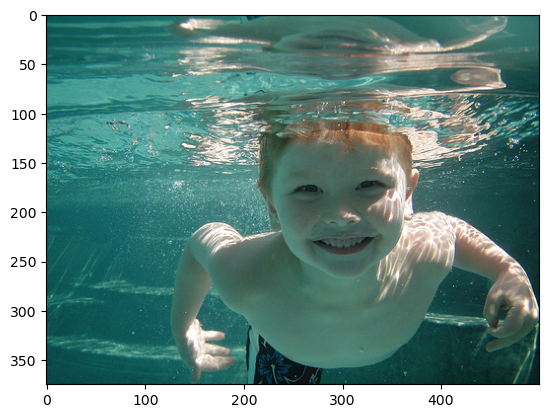

In [41]:
generate_caption("1096165011_cc5eb16aa6.jpg")

---------------------Actual---------------------
startseq brown dog is shaking his head while standing on sand endseq
startseq brown dog with large ears is shaking its self while standing on sand endseq
startseq an orange dog shakes his head very hard on the sand endseq
startseq tan dog shaking its body endseq
startseq the orange haired dog shook its head while standing on the beach endseq
--------------------Predicted--------------------
startseq golden retriever is running on beach endseq


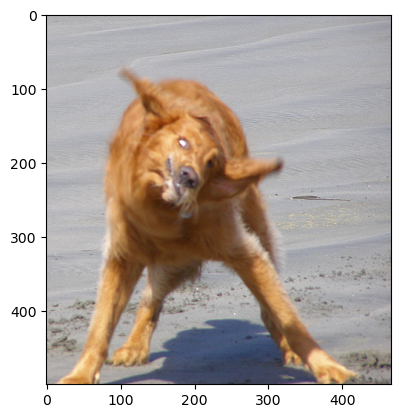

In [40]:
generate_caption("489372715_ce52da796a.jpg")

In [42]:
generate_caption('young skateboarder ramp.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'Flickr/Images/young skateboarder ramp.jpeg'